# Фильтр Калмана 
*Хромов Алексей*

## Одномерный случай

### Теория

Фильтр "Калмана" используют для фильтрации зашумленного сигнала. Модель сиглана обычно считается известа.
Фильтр Калмана основан на параметрическом g-h фильтре.

#### Предсказание

К примеру, рассмотрим одномерное движение с начальной координатой $x_0$ и скоростью $v$,  тогда модель выглядит сдеующим образом:
$$ x=x_0+vt\\ $$
Пусть мы имеем какую-то модель для сигнала и можем с какой-то вероятнотсью предсказывать следующие значния $\bar{x}_k$ из предыдущих $x_{k-1}$, тогда наша модель примет следущий вид:

$$ \begin{aligned} \bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

Наша модель очень проста, но мы не можем быть уверены в её правильности. Покажем нашу неуверенность через функции Гаусса:
$$\begin{gathered}
x=\mathcal N(\mu_x, \sigma_x^2)\\
f_x = \mathcal N (\mu_{f_x}, \sigma_{f_x}^2)
\end{gathered}$$
Теперь наша модель выглядит как:
$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 \end{aligned}$$
Сразу бросаетсся в глаза рост ошибки с каждым новым предсказанием. Действительно, ведь мы теряем информацию из-за неуверенности нашей модели, поэтому дисперсия постоянно растет.
 

#### Обновление

Теперь мы имеем два занчения:
- предсказанное с какой-то вероятностью значение $\bar \mu$
- зашумленное значение из сигнала $\mu_z$

Нам необходимо "выбрать" наивероятнейшее значение с учетом отклонений: 
$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$
Перепишем нашее выражение: 
$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$
И сделаем замену:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$
где $K$ - коэффициент са
$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

Коэффициент или вес филтра Калмана несет в себе вероятносстную ошибку, то есть он показывает, чему мы больше склонны доверять, нашей неточной модели или значнию зашумленного сигнала.

#### Вывод
Соберём теперь все вместе. 
- Сначала мы делаем прогноз будущего значения, на основе уже имеющихся данных
- Далее выбираем значение из сигнала
- В конце формирует новую оценку выбирая что-то между предсказанием и опытом

### Алгоритм фильтра Калмана

**Инициализация**

    1. Инициализируем начальные данные и состояние фильтра 
    2. Инициализируем вероятностные состояния, ошибки
    
**Прогнозирование**

    1. Прогнозируем состояние системы на следующем временном шаге, используя характеристики модели
    2. Вычисляем вероятность нашего прогноза, ошибку
    
**Обновление**

    1. Получаем измерение и ее точность
    2. Вычисляем невязку между расчетным состоянем и измерением
    3. Вычисляем коэффициент масштабирования 
    4. Выбираем состояние между прогнозом и измерением на основе масштабного коэффициента
    5. Обновляем вероятностную ошибку выбранного состояния

<u>Прогнозирование</u>

$\begin{array}{|l|l|l|}
\hline
\text{Реализация} & \text{Калмановская форма}\\
\hline
\bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
\bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Обновление</u>

$\begin{array}{|l|l|l|}
\hline
\text{Реализация}& \text{Калмановская форма}\\
\hline
y = z - \bar\mu & y = z - \bar x\\
K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
\mu = \bar \mu + Ky & x = \bar x + Ky\\
\sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$
### Реализация

Подключение библиотек и форматов для подсчета, построения графиков, рандома и Гаусса.

In [1]:
from __future__ import division, print_function
%matplotlib inline

import book_format
book_format.set_style()

import numpy as np
import random
import cmath
import matplotlib.pyplot as plt


from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

from ipywidgets import interact

Функция получения сигнала и зашумленного сигнала.

In [2]:
def signal(value, std, k):
    return value + ((random.randrange(0,2+k)-k) * std)


def signal_noise(value, std):
    return value + (random.uniform(-1,1) * std)

Наши фунции предсказания и обновеления

In [3]:
def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

In [4]:

from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])

In [5]:
def model(change, sensor_var, process_var, initial, N, k):
    
    x = gaussian(0, 1000.) # initial state
    process_model = gaussian(change, process_var)
    
    #N = 50
    z_orig = [initial]
    z_noise = [signal_noise(initial, sensor_var)]
    ps = []
    estimates = []
    predic = []
    
    
    for i in range(N):
        z_orig.append(signal(z_orig[i], change, k))
        z_noise.append(signal_noise(z_orig[i], sensor_var))
        
    
    for z in z_noise:
        prior = predict(x, process_model)
        x = update(prior, gaussian(z, sensor_var))
    
        # save for latter plotting
        estimates.append(x.mean)
        ps.append(x.var)
        predic.append(prior.mean)
        
    
        
    # plot the filter output and the variance
    book_plots.plot_measurements(z_noise)
    book_plots.plot_predictions(predic)
    plt.plot(z_orig, label='Original signal', color='r')
    book_plots.plot_filter(estimates, var=np.array(ps))
    book_plots.show_legend()
    #plt.ylim(5, 10)
    book_plots.set_labels(x='step', y='signal')
    plt.show()
        
    plt.plot(ps)
    plt.title('Variance')
    print('Variance converges to {:.3f}'.format(ps[-1]))
    




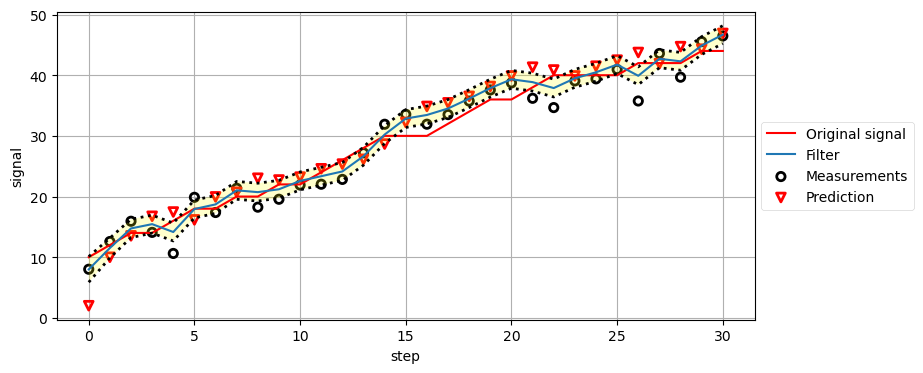

Variance converges to 2.162


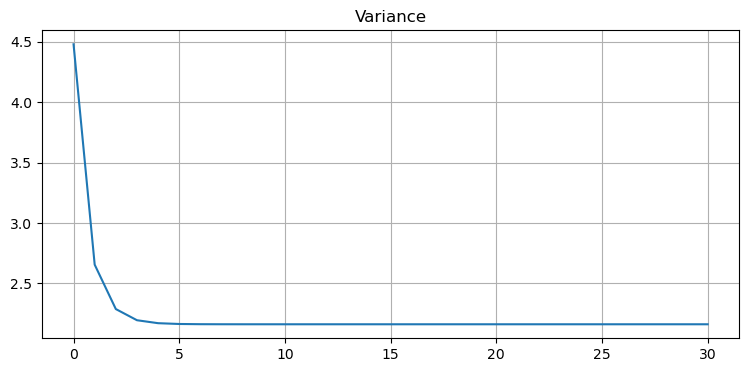

In [6]:
#interact(model,
#         change = (0., 10., 1), #step of the model
#         sensor_var = (0., 100., 1), #noise
#         process_var = (0., 10., 1), #device error
#         initial = (0., 20., 2),  #initial coordinate of the model
#         N = (0, 40, 5),
#         k = (0,1,1));  #random speed sign (if k==0 then speed_>0(onle))

change = 2.0 #step of the model
sensor_var = 4.5 #noise
process_var = 2 #device error
initial = 10  #initial coordinate of the model
N = 30
k = 0  #random speed sign {if k==0 then speed_>=0 (onle)}  {if k==1 then speed_>=0 || speed_<0 (onle)}




model(change, sensor_var, process_var, initial, N, k)

## Многомерный случай

### Алгоритм фильтра Калмана

#### Пердсказание

$\begin{array}{|l|l|l|}
\hline
\text{Многомерный случай}\\
\hline
\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$


$\mathbf x,\, \mathbf P$ это среднее значение и ковариационная матрица.

$\mathbf F$ функция перехода.

$\mathbf Q$ это процесс ковариации.

$\mathbf B$ и $\mathbf u$ динамические входы.

#### Обновление

$\begin{array}{|l|l|l|}
\hline
\text{Многомерный случай}\\
\hline
\mathbf y = \mathbf z - \mathbf{H\bar x} \\
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ измеряющая функция.

$\mathbf z,\, \mathbf R$ это среднее значение и ковариация шума. 

$\mathbf y$ и $\mathbf K$ это невязка и матрица Калмана.

### Реализация

Подключение библиотек и форматов для удобства работы с матрицами.

In [7]:
from scipy.linalg import block_diag
#from filterpy.common import Q_discrete_white_noise

#### Функции фильтра Калмана


In [8]:

def predict(x, P, F, Q, B, u):
    x = F @ x + B @ u
    P = F @ P @ F.T + Q
    return x, P


def update(x, P, z, R, H):
    I = np.eye(6)
    y = z - H @ x
    S = H @ P @ H.T + R
    S_1 = np.linalg.inv(S)
    K = P @ H.T @ S_1
    x = x + K @ y
    P = (I - K @ H) @ P
    return x, P


Моделирование процесса я вёл в декартовой системе координат, но так как измеряем (независимо) дальность до объекта и угол, то необходимо перевести координаты в полярную систему, это выполняется в функции **polar**. Также в ней идет зашумление сигнала через функцию **signal_noise** и перевод обратно в декартовую сисстему коордиинат.

In [9]:
def polar(x, y, r_noise, phi_noise):
    r = (x**2 + y**2) ** .5
    if x > 0:
        phi = cmath.atan((y) / (x)).real
    else:
        phi = 0
    r = signal_noise(r, r_noise)
    phi = signal_noise(phi, phi_noise)
     
    return np.array([r * cmath.cos(phi), r * cmath.sin(phi)]).T

Измерения ведудтся с частотой **Hz**, горизонтальная составляющая скорости камня **Vx**, вертикальная -   **Vy**. Ускорение свободного падения **g**.  Предпологаем, что мы ничего не знаем о нашем камне: ни скорости, ни координаты, ни его ускорения, пусть все его значения равны нулю:

$$
\mathbf{\bar x} = \begin{bmatrix}x \\ \dot x \\ \ddot x \\ y \\ \dot y \\ \ddot y\end{bmatrix} = \begin{bmatrix}0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}$$

И мы совсем не уверены в наших предположениях, поэтому ковариационная матрица:

$$\mathbf P = \begin{bmatrix}\sigma_x^2&0&0&0&0&0\\0&\sigma_{\dot x}^2&0&0&0&0\\0&0&\sigma_{\ddot x}^2 &0&0&0\\0&0&0&\sigma_{y}^2&0&0\\0&0&0&0&\sigma_{\dot y}^2&0\\0&0&0&0&0&\sigma_{\ddot y}^2\end{bmatrix} = \begin{bmatrix}500&0&0&0&0&0\\0&500&0&0&0&0\\0&0&500&0&0&0\\0&0&0&500&0&0\\0&0&0&0&500&0\\0&0&0&0&0&500\end{bmatrix}$$

Фактические значения ошибок для создания шума: **r_noise** для радиуса ($\sigma_r$м), **phi_noise** для угла($\sigma_{\varphi}$ рад). Предпологаемый спектр белого шума **Q_spector_noise** для настройки фильтра, обуславливает уровень нашего даверия фильтру:

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt = \begin{bmatrix}\Delta t^5/20 & \Delta t^4/8 & {\Delta t}^3/6 \\ \Delta t^4/8 & \Delta t^3/3 & \Delta t^2/2\\ \Delta t^3/6& \Delta t^2/2& dt\end{bmatrix}\cdot \text{Q_spector_noise},$$

где 

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix},$$

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \cdot Q_s,$$

$$Q_s = \text{Q_spector_noise.}$$

Измерения **z** уже в декартовой системе координат, мы осуществляем с ковариационной матрицей  **R**. Мы предполагаем, что переменные $x$ и $y$ являются независимыми белыми Гауссовыми процессами. То есть шум в $x$ никоим образом не зависит от шума в $y$:

$$\mathbf R = \begin{bmatrix}\sigma_x^2 & \sigma_y\sigma_x \\ \sigma_x\sigma_y & \sigma_{y}^2\end{bmatrix} 
= \begin{bmatrix}\sigma^2&0\\0&\sigma^2\end{bmatrix}$$

In [10]:
#Data initialization
Hz = 100 #measurement frequency
vx = 25.0 #speed by x
vy = 25.0 #speed by y
g = 10. #gravity acceleration

x_start = np.zeros(6) #the initial prediction
P_start = np.eye(6) * 500. #confidence in the initial prediction

Q_spector_noise  = 1000 #the density of the White noise / our trust in the filter
r_noise = 5. #noise sqrt(dispersion) at the radius
phi_noise = .1 #noise sqrt(dispersion) at the angle
R = np.eye(2) * r_noise**2 #covariance matrix of measurements


dt = 1 / Hz
TIME = int(vy * 2 / g / dt) #set of dimensions
print("number of dimensions = ", TIME)

B = np.zeros(3)
u = np.zeros(3)

#
#Continuous White Noise Model
#
#Q = Q_discrete_white_noise(dim=3, dt = 0.001, var=30)
#print("Q = \n", Q)

Q = np.array([[dt**5/20, dt**4/8, dt**3/6],
              [dt**4/8,  dt**3/3, dt**2/2],
              [dt**3/6,  dt**2/2, dt]])
Q = Q * Q_spector_noise 
Q = block_diag(Q, Q)
print("Q = \n", Q)

#
#Modeling a Dynamic System
#
F = np.array([[1., dt, dt**2/2],
              [0., 1., dt     ],
              [0., 0., 1.     ]])
F = block_diag(F, F)
print("F = \n", F)

#
#Process modeling
#
x = np.array([0. , vx, 0., 0., vy, -g]).T          
P = P_start 

#flight path buffer
arr1x_orig = [0]
arr1y_orig = [0]

for i in range(TIME):
    x, P = predict(x, P, F, Q, B, u)
    arr1x_orig.append(x[0])
    arr1y_orig.append(x[3])
    

number of dimensions =  500
Q = 
 [[ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.05  0.    0.    0.  ]
 [ 0.    0.05 10.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.05]
 [ 0.    0.    0.    0.    0.05 10.  ]]
F = 
 [[1.   0.01 0.   0.   0.   0.  ]
 [0.   1.   0.01 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.01 0.  ]
 [0.   0.   0.   0.   1.   0.01]
 [0.   0.   0.   0.   0.   1.  ]]


/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


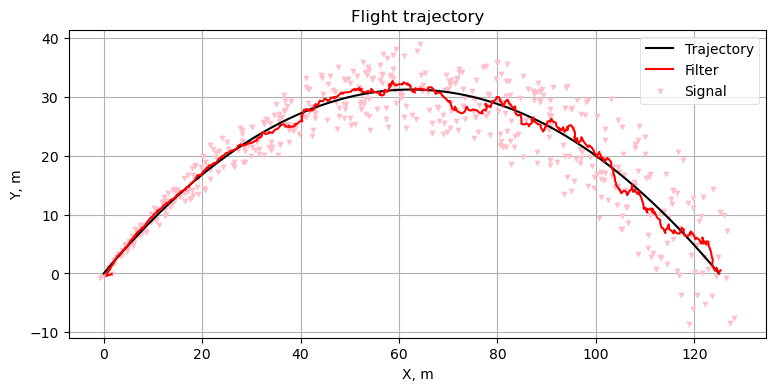

In [11]:

H = np.array([[1., 0., 0., 0., 0., 0.],
              [0., 0., 0., 1., 0., 0.]])

x = x_start 
P = P_start 

#flight path buffer
#filter
arr_x = [] 
arr_y = []
#flight path buffer
#measurements
arrz_x = []
arrz_y = []

#flight path buffer
evaluation_sub_realx = []
measurement_sub_realx = []
evaluation_sub_realy = []
measurement_sub_realy = []

#flight path buffer
bufx = []
bufy = []

z_data = []


for i in range(TIME):
    z = polar(arr1x_orig [i] , arr1y_orig [i], r_noise, phi_noise) #getting measurements with noise
    #z = np.array([signal_noise(arr1x_orig [i], 3.), signal_noise(arr1y_orig [i], 3.)]).T
    x, P = predict(x, P, F, Q, B, u)
    x, P = update(x, P, z, R, H)
    
    z_data.append(z)
    
    arrz_x.append(z[0])
    arrz_y.append(z[1])
    
    arr_x.append(x[0])
    arr_y.append(x[3])
    
    evaluation_sub_realx.append(x[0] - arr1x_orig [i])
    evaluation_sub_realy.append(x[3] - arr1y_orig [i])
    measurement_sub_realx.append(z[0] - arr1x_orig [i])
    measurement_sub_realy.append(z[1] - arr1y_orig [i])
    bufx.append(P[0][0])
    bufy.append(P[3][3])

plt.title('Flight trajectory')
plt.ylabel('Y, m')
plt.xlabel('X, m')
plt.scatter(arrz_x, arrz_y, label = u'Signal', marker='v', s=13, color='pink')
plt.plot(arr1x_orig, arr1y_orig, label = u'Trajectory', color = 'black')
plt.plot(arr_x, arr_y, label = u'Filter', color = 'r')
plt.legend()
plt.show()
    
    

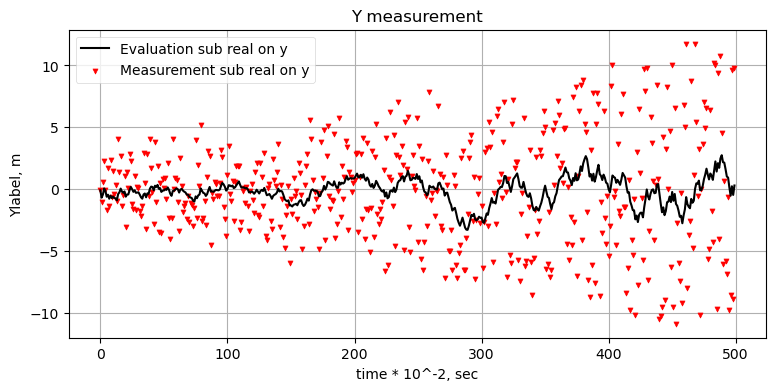

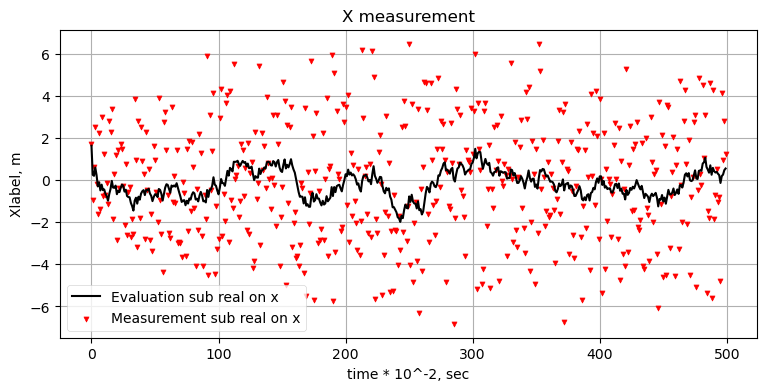

In [12]:
plt.title('Y measurement')
plt.ylabel('Ylabel, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(evaluation_sub_realy, label = u'Evaluation sub real on y', color = 'black')
plt.scatter(range(TIME), measurement_sub_realy, label = u'Measurement sub real on y', marker='v', s=13, color = 'r')
plt.legend()
plt.show()

plt.title('X measurement')
plt.ylabel('Xlabel, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(evaluation_sub_realx, label = u'Evaluation sub real on x', color = 'black')
plt.scatter(range(TIME), measurement_sub_realx, label = u'Measurement sub real on x', marker='v', s=13, color = 'r')
plt.legend()
plt.show()

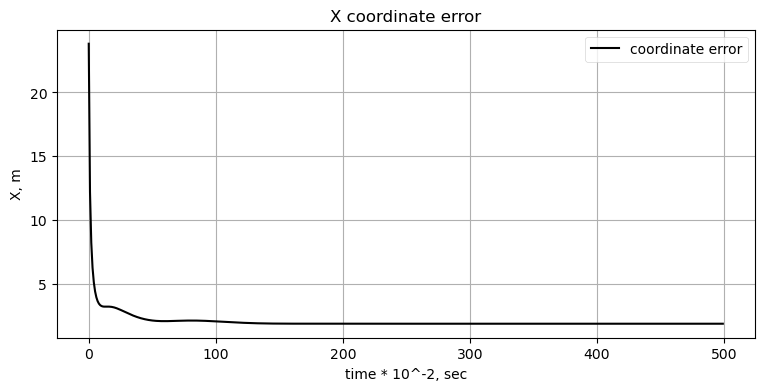

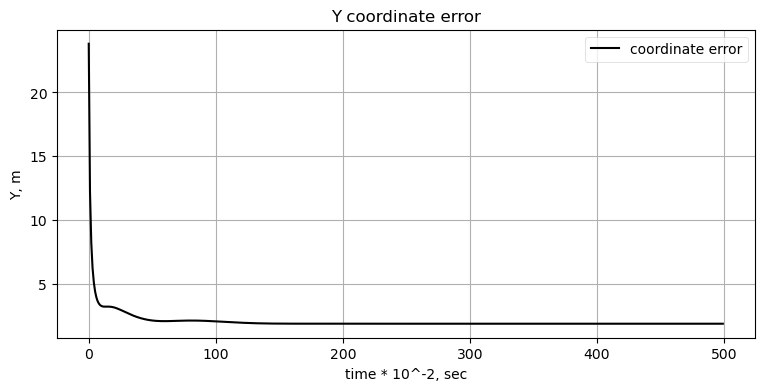

In [19]:
plt.title('X coordinate error')
plt.ylabel('X, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(bufx, label = u'coordinate error', color = 'black')
plt.legend()
plt.show()

plt.title('Y coordinate error')
plt.ylabel('Y, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(bufy, label = u'coordinate error', color = 'black')
plt.legend()
plt.show()

In [14]:
def predict(x, P, F, Q, B, u):
    x = F @ x + B @ u
    P = F @ P @ F.T + Q
    return x, P

def update(x, P, z, R, H, size_coordinates):
    I = np.eye(3*size_coordinates)
    y = z - H @ x
    S = H @ P @ H.T + R
    S_1 = np.linalg.inv(S)
    K = P @ H.T @ S_1
    x = x + K @ y
    P = (I - K @ H) @ P
    return x, P


def FilterKalman(trajectories, size_coordinates, time_step, Q_spector_noise, coordinates_noise, B = None, U = None):
    assert size_coordinates in [1, 2, 3]
    
    dt = time_step

    R = np.eye(size_coordinates) * coordinates_noise**2 #covariance matrix of measurements
    if B == None:
        B = np.zeros(size_coordinates)
    if U == None:
        u = np.zeros(size_coordinates)


    Q = np.array([[dt**5/20, dt**4/8, dt**3/6],
                  [dt**4/8,  dt**3/3, dt**2/2],
                  [dt**3/6,  dt**2/2, dt]])
    Q = Q * Q_spector_noise

    F = np.array([[1., dt, dt**2/2],
                  [0., 1., dt     ],
                  [0., 0., 1.     ]])
    
    H = np.array([1., 0., 0.])
    
    if size_coordinates==3:
        F = block_diag(F, F, F)
        Q = block_diag(Q, Q, Q)
        H = block_diag(H, H, H)
    elif size_coordinates==2:
        F = block_diag(F, F)
        Q = block_diag(Q, Q)
        H = block_diag(H, H)

    x = np.zeros(3*size_coordinates) #the initial prediction
    P = np.eye(3*size_coordinates) * 500. #confidence in the initial prediction

    trajectories_filter = []
    trajectories_filter_x = []
    trajectories_filter_P = []
    
    for id_p, point in enumerate(trajectories):
        x, P = predict(x, P, F, Q, B, u)
        x, P = update(x, P, point, R, H, size_coordinates)
        trajectories_filter.append(x[0::3])
        trajectories_filter_P.append(P[0::3,0::3]@np.ones(size_coordinates))

    return trajectories_filter, trajectories_filter_P

In [15]:
Q_spector_noise  = 1000 #the density of the White noise / our trust in the filter
coordinates_noise = 5. #noise sqrt(dispersion) at the radius
size_coordinates = 2
time_step = dt

In [16]:
data_trajectories_filter = []
data_trajectories_filter_P = []

traj, traj_P = FilterKalman(z_data, size_coordinates, time_step, Q_spector_noise, coordinates_noise)

/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


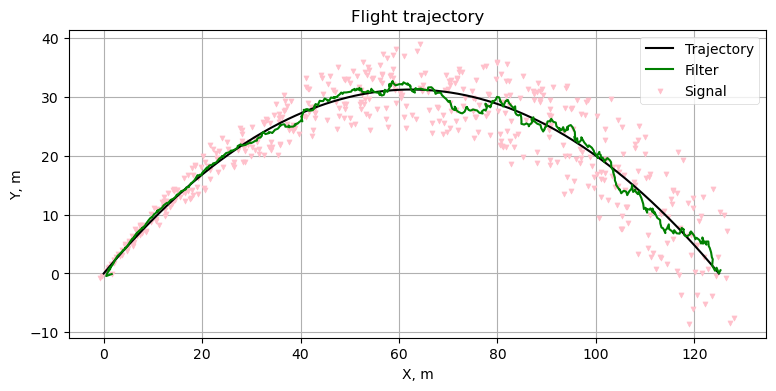

In [21]:

plt.title('Flight trajectory')
plt.ylabel('Y, m')
plt.xlabel('X, m')
plt.scatter(arrz_x, arrz_y, label = u'Signal', marker='v', s=13, color='pink')
plt.plot(arr1x_orig, arr1y_orig, label = u'Trajectory', color = 'black')
plt.plot(np.array(traj)[:,0], np.array(traj)[:,1], label = u'Filter', color = 'g')
plt.legend()
plt.show()

/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


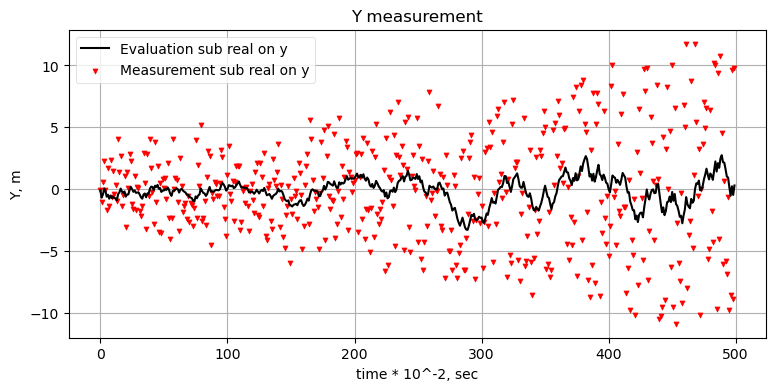

/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/alexkhromov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


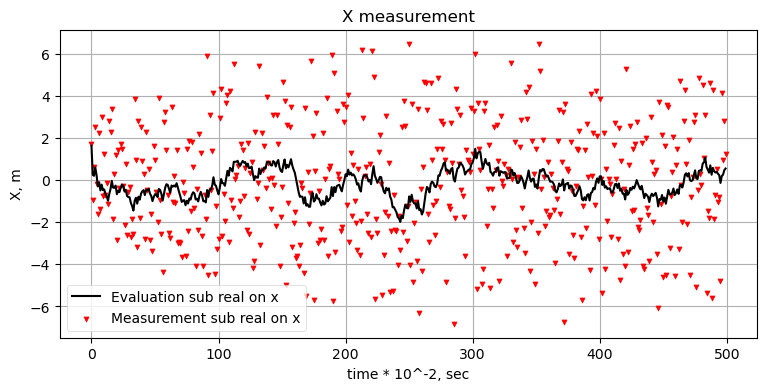

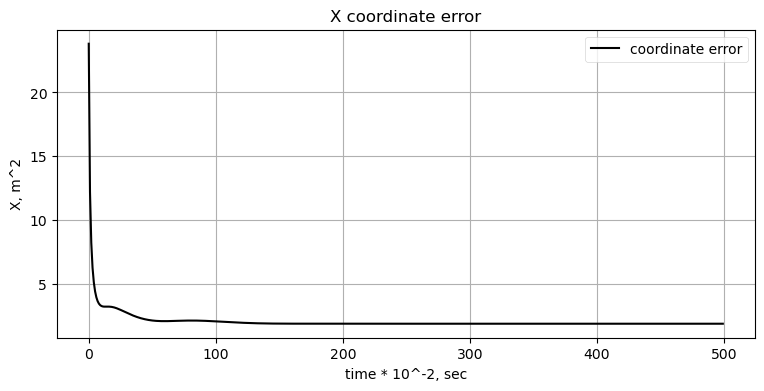

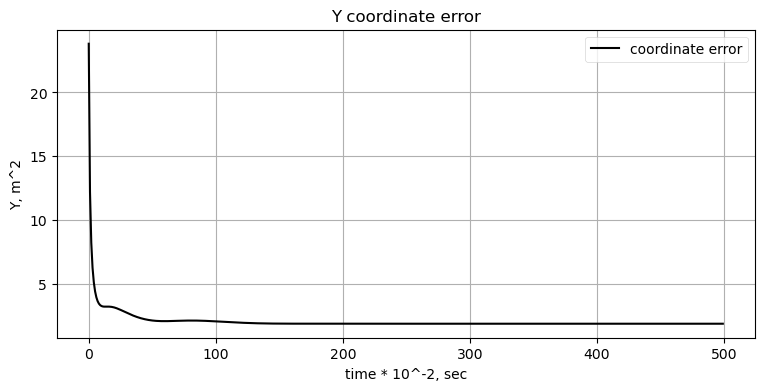

In [23]:
plt.title('Y measurement')
plt.ylabel('Y, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(np.array(traj)[:,1] - arr1y_orig[:-1], label = u'Evaluation sub real on y', color = 'black')
plt.scatter(range(TIME), measurement_sub_realy, label = u'Measurement sub real on y', marker='v', s=13, color = 'r')
plt.legend()
plt.show()

plt.title('X measurement')
plt.ylabel('X, m')
plt.xlabel('time * 10^-2, sec')
plt.plot(np.array(traj)[:,0] - arr1x_orig[:-1], label = u'Evaluation sub real on x', color = 'black')
plt.scatter(range(TIME), measurement_sub_realx, label = u'Measurement sub real on x', marker='v', s=13, color = 'r')
plt.legend()
plt.show()

plt.title('X coordinate error')
plt.ylabel('X, m^2')
plt.xlabel('time * 10^-2, sec')
plt.plot(np.array(traj_P)[:,0], label = u'coordinate error', color = 'black')
plt.legend()
plt.show()

plt.title('Y coordinate error')
plt.ylabel('Y, m^2')
plt.xlabel('time * 10^-2, sec')
plt.plot(np.array(traj_P)[:,1], label = u'coordinate error', color = 'black')
plt.legend()
plt.show()